In [58]:
import os
import pyspark

# Set Java options before creating SparkSession
os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.driver.extraJavaOptions="-Djava.security.manager=allow" --conf spark.executor.extraJavaOptions="-Djava.security.manager=allow" pyspark-shell'

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DiamondAnalysis") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

In [59]:
diamonds = spark.read.csv(
    "diamonds.csv",
    header=True,
    inferSchema=True
)


In [60]:
diamonds.count()

53940

In [61]:
diamonds.printSchema()

root
 |-- rownames: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [62]:
display(diamonds.show())

+--------+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|rownames|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+--------+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|       1| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
|       2| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
|       3| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
|       4| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
|       5| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
|       6| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
|       7| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
|       8| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
|       9| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
|      10| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|      11|  0.3|     Good|    J|    SI

None

In [63]:
display(diamonds)

DataFrame[rownames: int, carat: double, cut: string, color: string, clarity: string, depth: double, table: double, price: int, x: double, y: double, z: double]

In [64]:
display(diamonds.describe("carat","price"))

DataFrame[summary: string, carat: string, price: string]

In [65]:
expensive_diamonds = diamonds.where(diamonds["price"] > 15000)

In [66]:
expensive_diamonds.count()

1655

In [67]:
dimonds_cut = diamonds.select("cut", "price").groupBy("cut").avg("price")

In [68]:
display(dimonds_cut)

DataFrame[cut: string, avg(price): double]

In [69]:
from pyspark.sql.functions import avg

# Create a new dataframe df_color that calculates the average price per color, sorted by color
df_color = diamonds.groupBy("color").agg(avg("price").alias("avg_price")).orderBy("color")
df_color.show()

+-----+------------------+
|color|         avg_price|
+-----+------------------+
|    D|3169.9540959409596|
|    E|3076.7524752475247|
|    F| 3724.886396981765|
|    G| 3999.135671271697|
|    H| 4486.669195568401|
|    I| 5091.874953891553|
|    J|  5323.81801994302|
+-----+------------------+



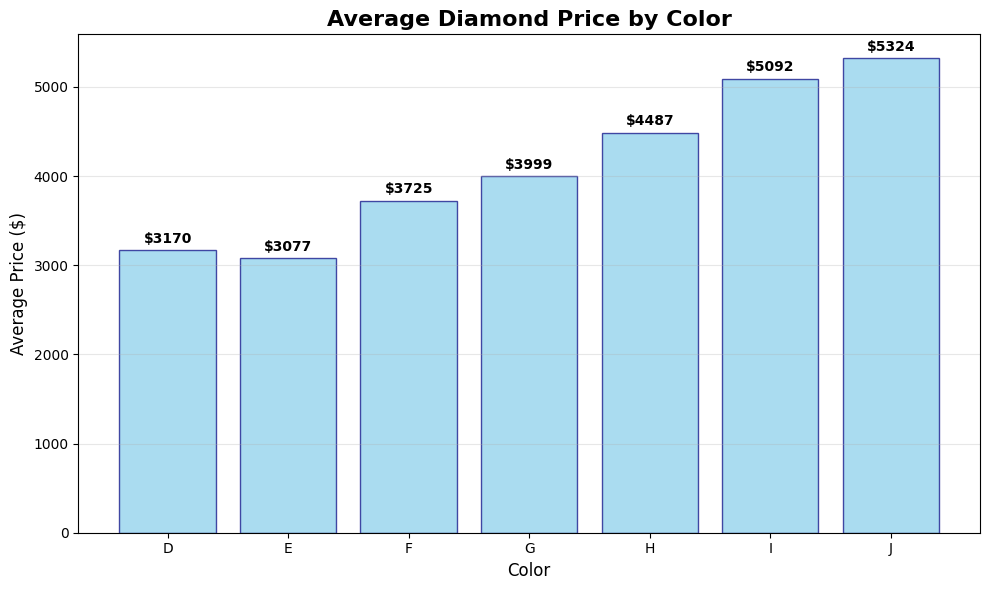

In [70]:
import matplotlib.pyplot as plt

# Collect the data for visualization
color_data = df_color.collect()
colors = [row['color'] for row in color_data]
avg_prices = [row['avg_price'] for row in color_data]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(colors, avg_prices, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Average Diamond Price by Color', fontsize=16, fontweight='bold')
plt.xlabel('Color', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(avg_prices):
    plt.text(i, v + 50, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [71]:
# Create dataframe with average price per all 4 Cs (color, carat, cut, clarity)
dimonds_prices = diamonds.groupBy("color", "carat", "cut", "clarity").agg(avg("price").alias("avg_price"))
dimonds_prices.show(20)

print(f"Total combinations of 4 Cs: {dimonds_prices.count()}")

+-----+-----+---------+-------+------------------+
|color|carat|      cut|clarity|         avg_price|
+-----+-----+---------+-------+------------------+
|    E| 0.23|Very Good|    VS2|             388.5|
|    E| 0.81|  Premium|    SI2|2609.3333333333335|
|    E|  0.9|  Premium|    SI2|            3636.0|
|    H|  0.8|    Ideal|    VS1|3329.3333333333335|
|    D| 0.84|Very Good|    SI2|            3145.0|
|    D|  0.9|  Premium|    SI2|3606.4285714285716|
|    E| 0.82|    Ideal|    SI1|3685.3333333333335|
|    D| 1.03|     Good|    SI2|            4049.5|
|    E| 0.95|  Premium|    SI2|4039.6666666666665|
|    D| 0.57|Very Good|     IF|            4032.0|
|    G| 0.33|Very Good|    VS2| 579.3846153846154|
|    I|  1.1|  Premium|    SI1|            4579.4|
|    H| 1.11|  Premium|    VS1|            4687.0|
|    H| 1.09|     Good|    SI1|            4853.5|
|    J| 1.52|     Fair|    SI2|            5916.0|
|    E| 1.07|Very Good|    VS2|            6280.5|
|    F| 1.22|    Ideal|    SI1|

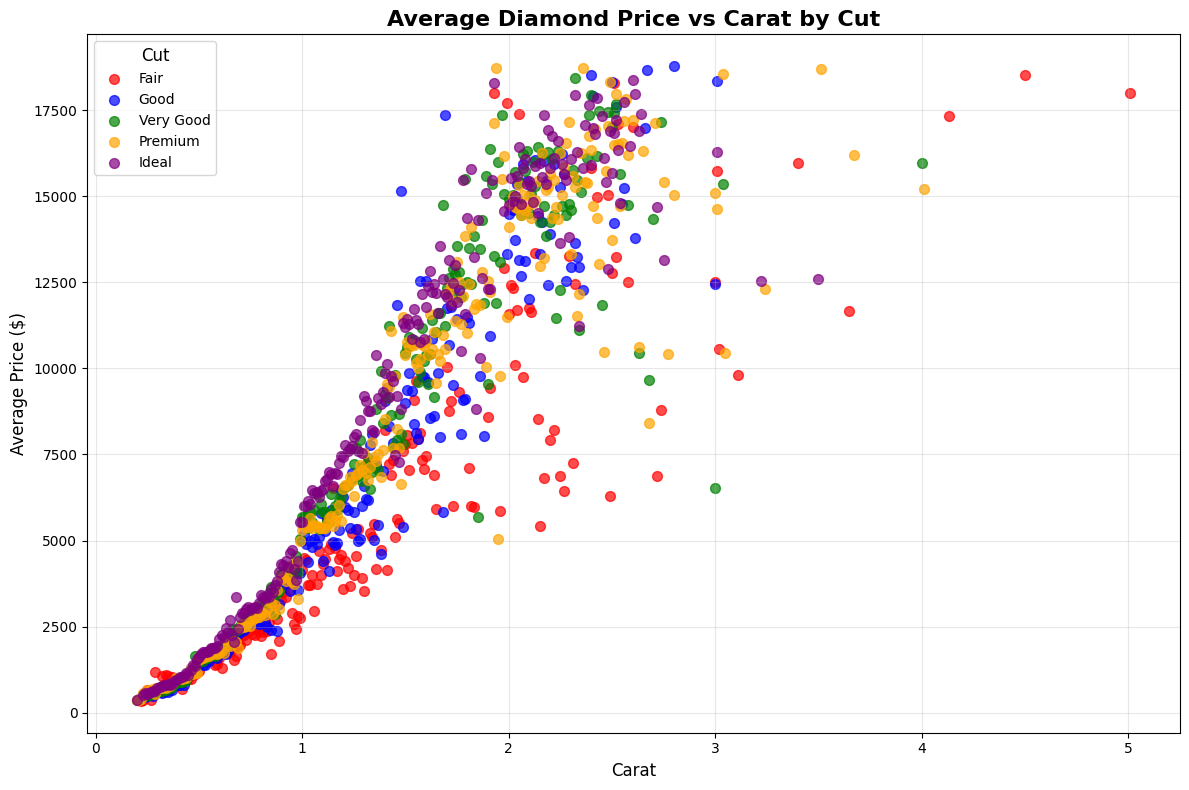

In [72]:
# Group by carat and cut to get average prices
carat_cut_prices = diamonds.groupBy("carat", "cut").agg(avg("price").alias("avg_price")).orderBy("carat", "cut")
carat_cut_data = carat_cut_prices.collect()

# Organize data by cut for plotting
cuts = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
cut_data = {cut: {"carat": [], "avg_price": []} for cut in cuts}

for row in carat_cut_data:
    cut = row['cut']
    if cut in cut_data:
        cut_data[cut]["carat"].append(row['carat'])
        cut_data[cut]["avg_price"].append(row['avg_price'])

# Create scatterplot
plt.figure(figsize=(12, 8))
colors_cut = ['red', 'blue', 'green', 'orange', 'purple']

for i, cut in enumerate(cuts):
    if cut_data[cut]["carat"]:  # Only plot if there's data
        plt.scatter(cut_data[cut]["carat"], cut_data[cut]["avg_price"], 
                   c=colors_cut[i], label=cut, alpha=0.7, s=50)

plt.title('Average Diamond Price vs Carat by Cut', fontsize=16, fontweight='bold')
plt.xlabel('Carat', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.legend(title='Cut', title_fontsize=12, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()